In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import os
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Step 1: Load the dataset

file_path = "/content/drive/MyDrive/Data Science Projects/App/app/static/chrun.csv"
data = pd.read_csv(file_path)
output_path = "/content/drive/MyDrive/Data Science Projects/App/app/static"
os.makedirs(output_path, exist_ok=True)


In [4]:
# Step 2: Explore the data

print("Data Head:\n", data.head())
print("\nData Info:\n", data.info())
print("\nData Description:\n", data.describe())

Data Head:
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        C

In [5]:
# Step 3: Column details

print("\nColumn Details:")
for col in data.columns:
    print(f"Column: {col}, Type: {data[col].dtype}, Unique values: {data[col].nunique()}")



Column Details:
Column: customerID, Type: object, Unique values: 7043
Column: gender, Type: object, Unique values: 2
Column: SeniorCitizen, Type: int64, Unique values: 2
Column: Partner, Type: object, Unique values: 2
Column: Dependents, Type: object, Unique values: 2
Column: tenure, Type: int64, Unique values: 73
Column: PhoneService, Type: object, Unique values: 2
Column: MultipleLines, Type: object, Unique values: 3
Column: InternetService, Type: object, Unique values: 3
Column: OnlineSecurity, Type: object, Unique values: 3
Column: OnlineBackup, Type: object, Unique values: 3
Column: DeviceProtection, Type: object, Unique values: 3
Column: TechSupport, Type: object, Unique values: 3
Column: StreamingTV, Type: object, Unique values: 3
Column: StreamingMovies, Type: object, Unique values: 3
Column: Contract, Type: object, Unique values: 3
Column: PaperlessBilling, Type: object, Unique values: 2
Column: PaymentMethod, Type: object, Unique values: 4
Column: MonthlyCharges, Type: float

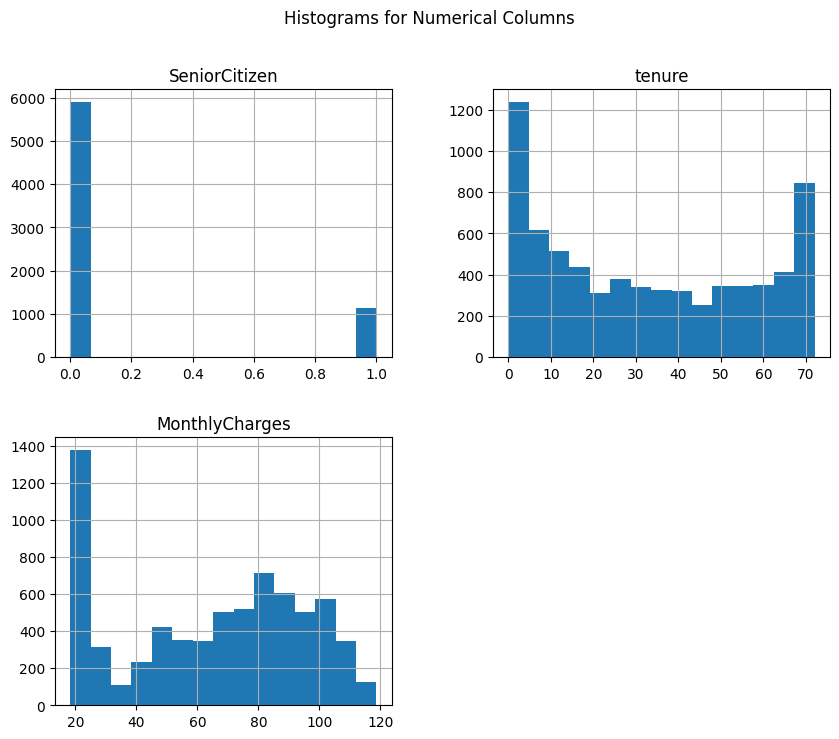

In [6]:
# Step 4: Visualize histograms for each numerical column

data.hist(bins=15, figsize=(10, 8))
plt.suptitle("Histograms for Numerical Columns")
# plt.show()
plt.savefig(os.path.join(output_path, "chrun_histograms.png"))


In [7]:
# Step 5: Handle missing values

# Display the number of missing values per column
print("Number of missing values in each column before filling:")
print(data.isnull().sum())

# Save the mean values for numerical columns with missing values
mean_values_with_na = data.mean(numeric_only=True)

# Save the mode values for categorical columns with missing values
mode_values_with_na = data.mode().iloc[0]

# Fill missing values with the mean of numerical columns and mode of categorical columns
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if data[column].isnull().any():
            data[column].fillna(mode_values_with_na[column], inplace=True)
    else:  # Numerical columns
        if data[column].isnull().any():
            data[column].fillna(mean_values_with_na[column], inplace=True)


Number of missing values in each column before filling:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [8]:
# Display the mean/mode values used to fill each column with missing values
print("\nValues used to fill columns with missing values:")
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if column in mode_values_with_na:
            print(f"{column}: {mode_values_with_na[column]}")
    else:  # Numerical columns
        if column in mean_values_with_na:
            print(f"{column}: {mean_values_with_na[column]}")



Values used to fill columns with missing values:
customerID: 0002-ORFBO
gender: Male
SeniorCitizen: 0.1621468124378816
Partner: No
Dependents: No
tenure: 32.37114865824223
PhoneService: Yes
MultipleLines: No
InternetService: Fiber optic
OnlineSecurity: No
OnlineBackup: No
DeviceProtection: No
TechSupport: No
StreamingTV: No
StreamingMovies: No
Contract: Month-to-month
PaperlessBilling: Yes
PaymentMethod: Electronic check
MonthlyCharges: 64.76169246059918
TotalCharges:  
Churn: No


In [9]:
# Step 6: Identify and remove outliers using IQR (Interquartile Range)

# Identifying outliers for each numeric column
outlier_columns = []
outliers_dict = {}

# Iterate over each numeric column in the dataset
for feature in data.select_dtypes(include=[np.number]).columns:
    # Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR (Interquartile Range)
    Q1 = data[feature].quantile(0.25)  # 25th percentile
    Q3 = data[feature].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range (difference between Q3 and Q1)

    # Identify outliers using the IQR rule: values lower than Q1 - 1.5 * IQR or higher than Q3 + 1.5 * IQR
    outlier_mask = (data[feature] < (Q1 - 1.5 * IQR)) | (data[feature] > (Q3 + 1.5 * IQR))

    # If there are any outliers for this feature, store them in the outliers_dict
    if outlier_mask.any():  # If there is at least one outlier
        outliers_dict[feature] = data[outlier_mask]  # Store outliers in the dictionary
        outlier_columns.append(feature)  # Add the feature name to the outlier_columns list



Outliers Detected for SeniorCitizen:
      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
20    8779-QRDMV    Male              1      No         No       1   
30    3841-NFECX  Female              1     Yes         No      71   
31    4929-XIHVW    Male              1     Yes         No       2   
34    3413-BMNZE    Male              1      No         No       1   
50    8012-SOUDQ  Female              1      No         No      43   
...          ...     ...            ...     ...        ...     ...   
7023  1035-IPQPU  Female              1     Yes         No      63   
7029  2235-DWLJU  Female              1      No         No       6   
7031  3605-JISKB    Male              1     Yes         No      55   
7032  6894-LFHLY    Male              1      No         No       1   
7041  8361-LTMKD    Male              1     Yes         No       4   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
20             No  No phone service           

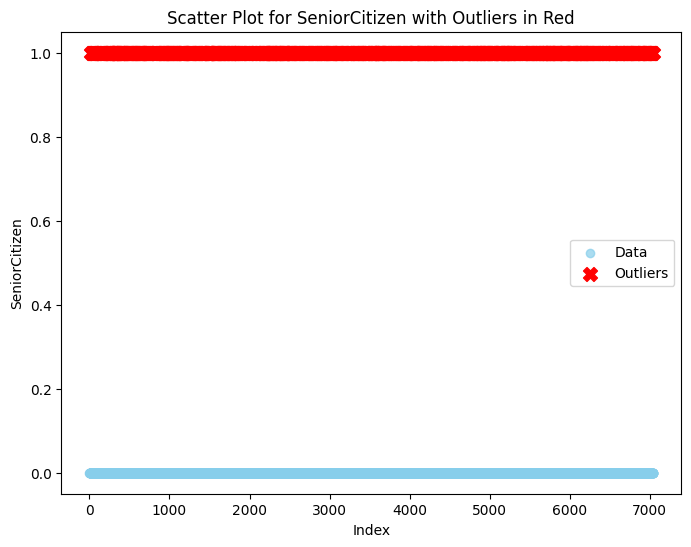

In [11]:
# Generate scatter plots only for the columns that contain outliers
for feature in outlier_columns:
    plt.figure(figsize=(8, 6))  # Create a figure for the scatter plot

    # Plot all data points (excluding outliers) for the feature
    non_outliers = data[~outlier_mask]  # Data without outliers
    plt.scatter(non_outliers.index, non_outliers[feature], color='skyblue', label="Data", alpha=0.7)

    # Plot the outliers in red
    outliers = outliers_dict[feature]  # Get the outliers for the current feature
    plt.scatter(outliers.index, outliers[feature], color='red', label="Outliers", s=100, marker='X')

    # Set title and labels for the plot
    plt.title(f"Scatter Plot for {feature} with Outliers in Red")
    plt.xlabel('Index')
    plt.ylabel(feature)
    plt.legend()
    # plt.show()
    plot_filename = f"chrun_scatter_{feature}.png"  # Use feature name in the file
    plt.savefig(os.path.join(output_path, plot_filename))

    # Print the outliers detected for the current feature
    print(f"\nOutliers Detected for {feature}:")
    print(outliers)

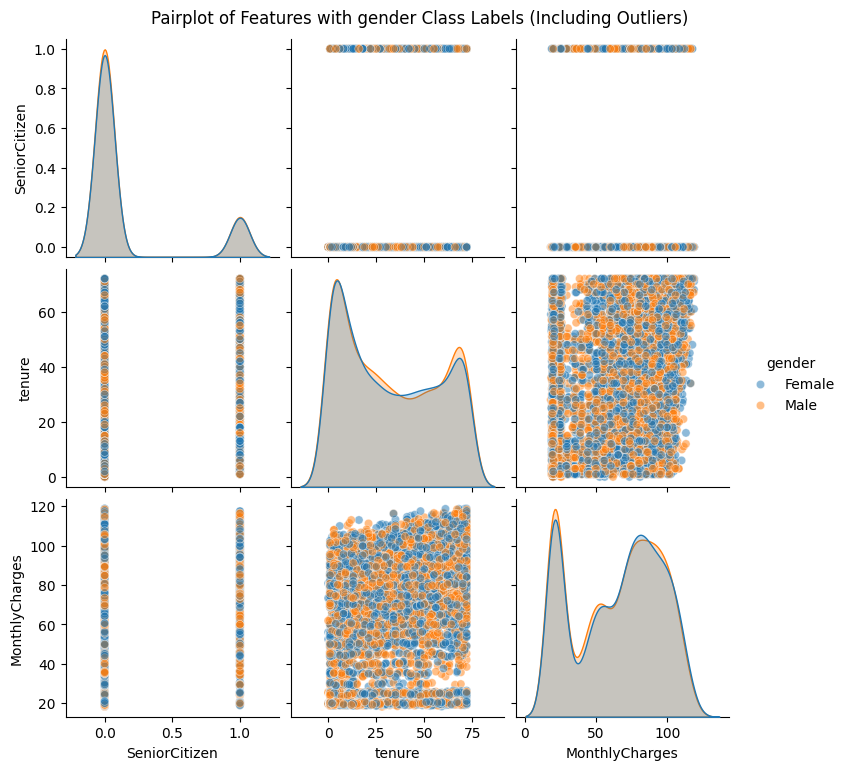

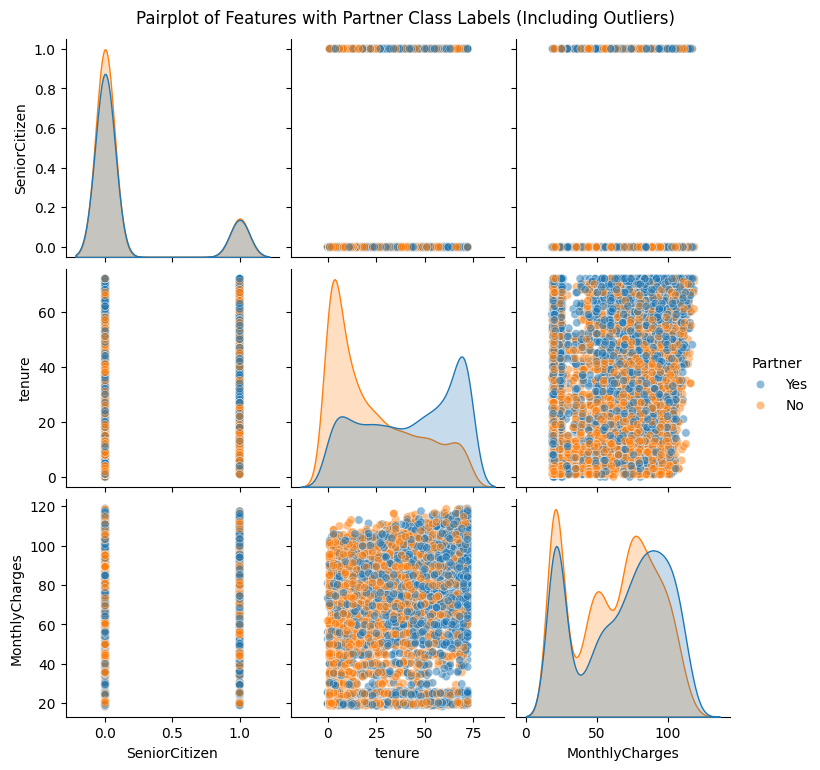

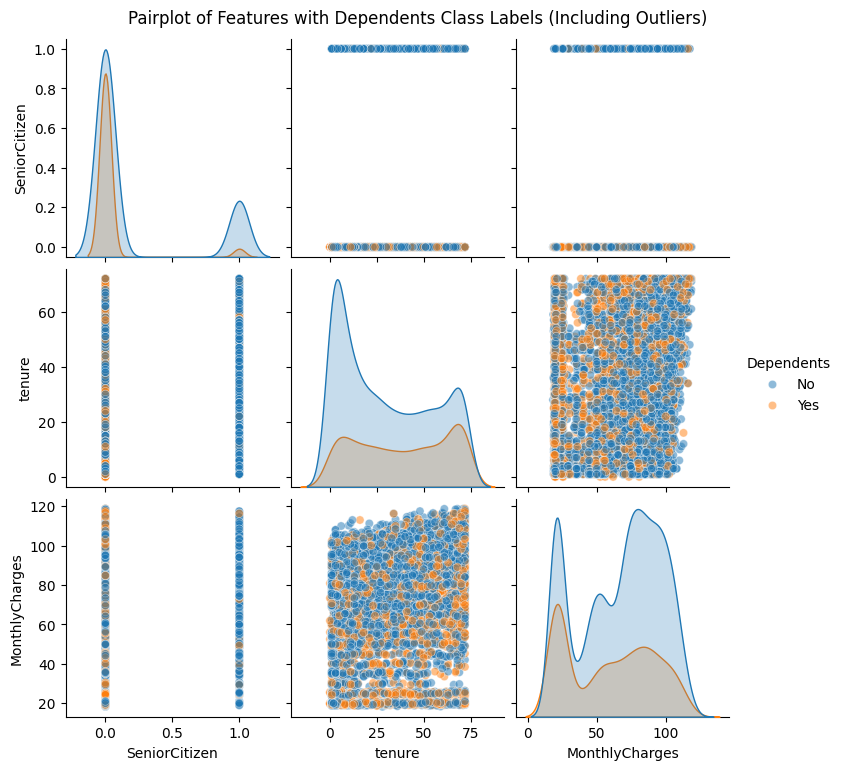

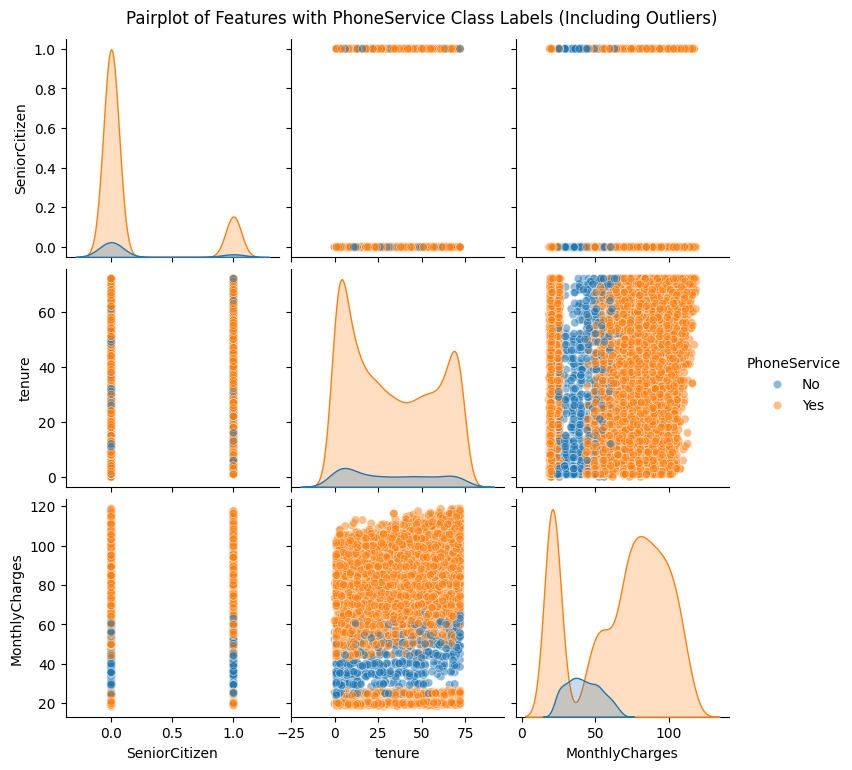

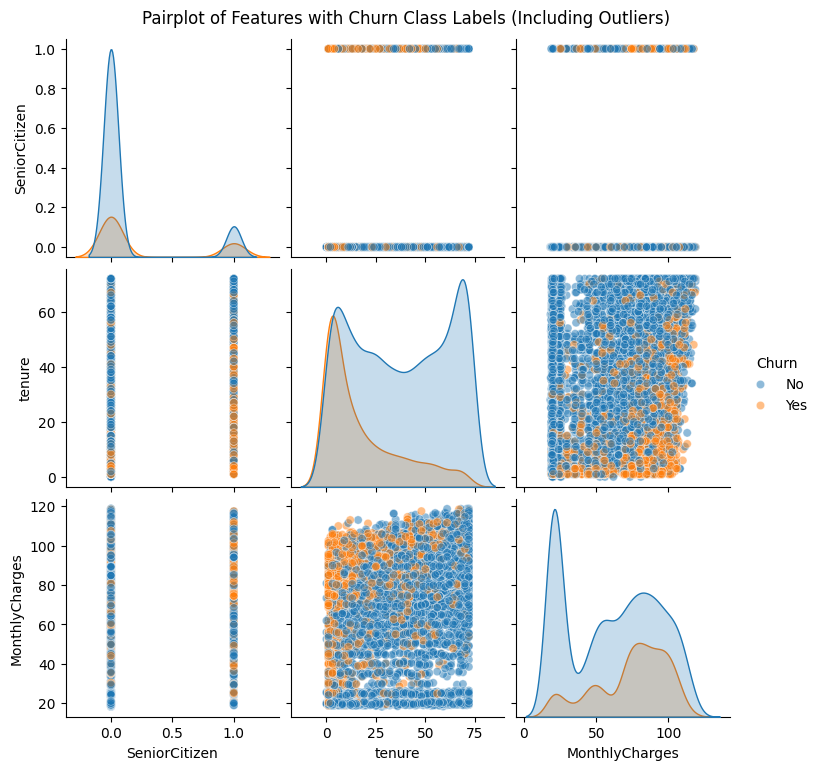

In [13]:
# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='gender', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with gender Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "chrun_outliers_gender.png"))

sns.pairplot(data, hue='Partner', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Partner Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "chrun_outliers_Partner.png"))

sns.pairplot(data, hue='Dependents', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Dependents Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "chrun_outliers_Dependents.png"))
# Remove the outliers from the dataset

sns.pairplot(data, hue='PhoneService', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with PhoneService Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "chrun_outliers_PhoneService.png"))
cleaned_data = data.copy()

sns.pairplot(data, hue='Churn', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Churn Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "chrun_outliers_Churn.png"))
cleaned_data = data.copy()

In [14]:
# Loop through outlier columns to remove outliers
for feature in outlier_columns:
    outliers = outliers_dict[feature]  # Get outliers for the current feature
    cleaned_data = cleaned_data[~cleaned_data.index.isin(outliers.index)]  # Remove rows with outliers


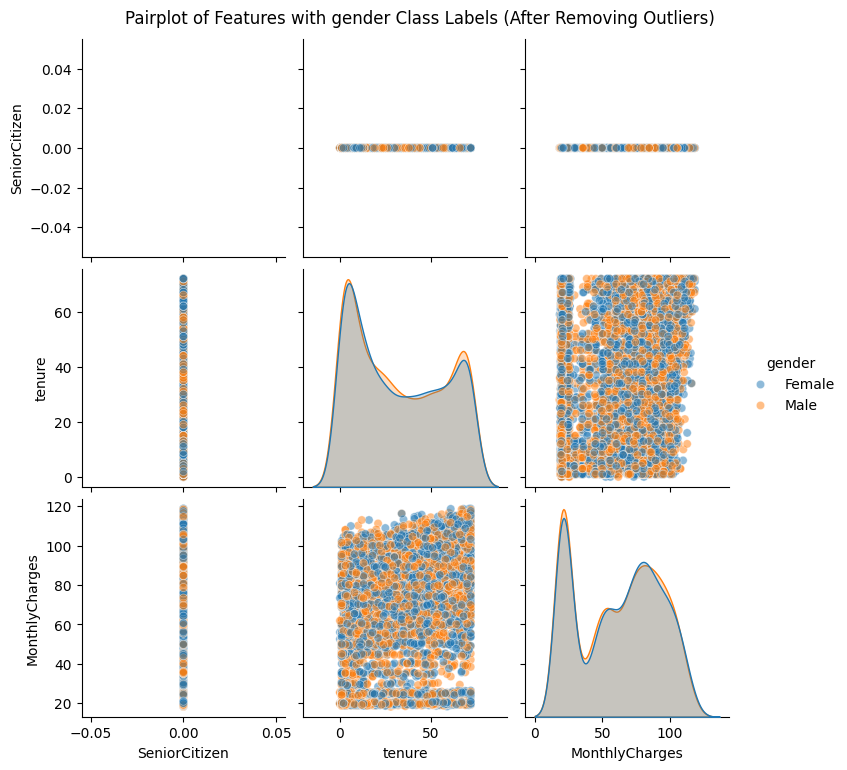

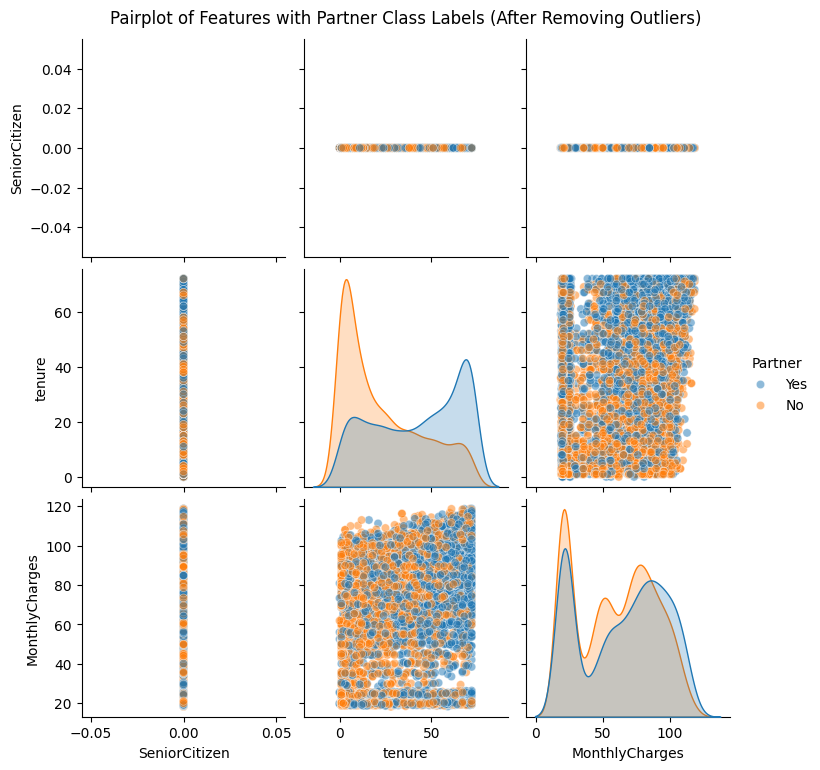

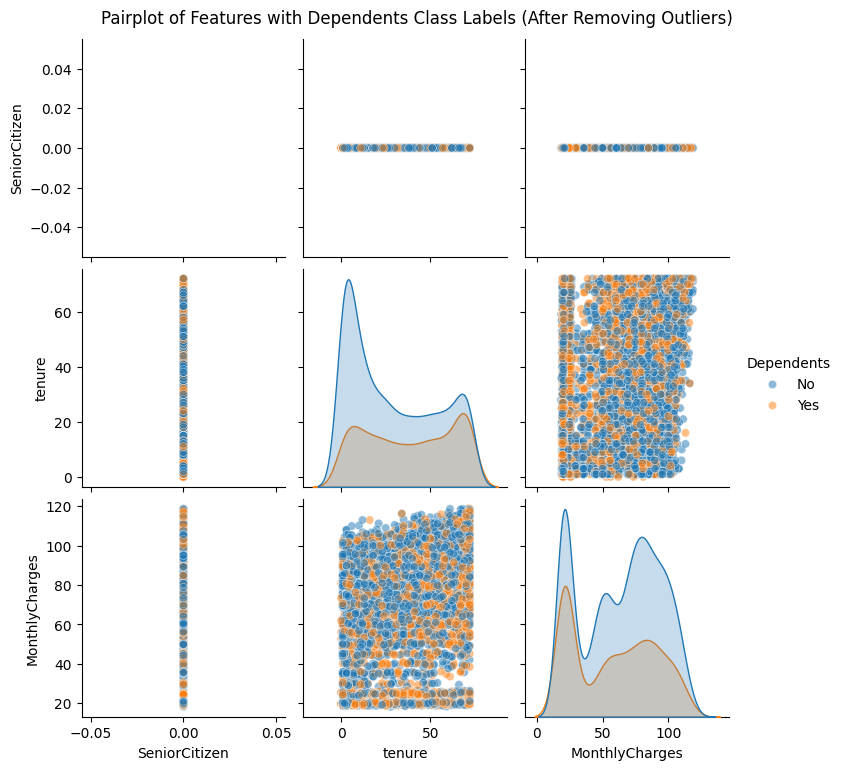

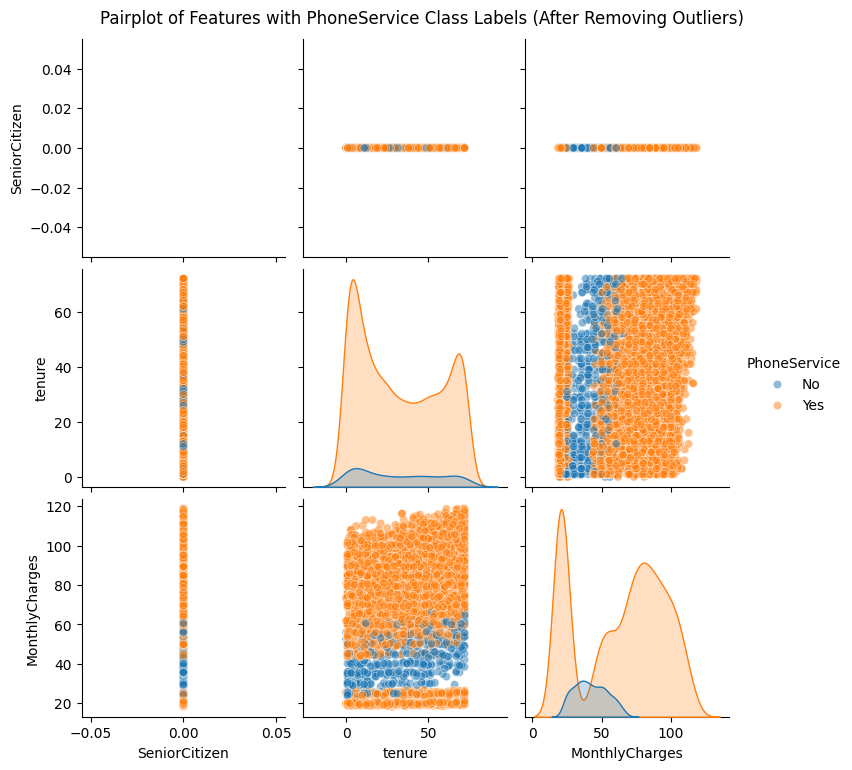

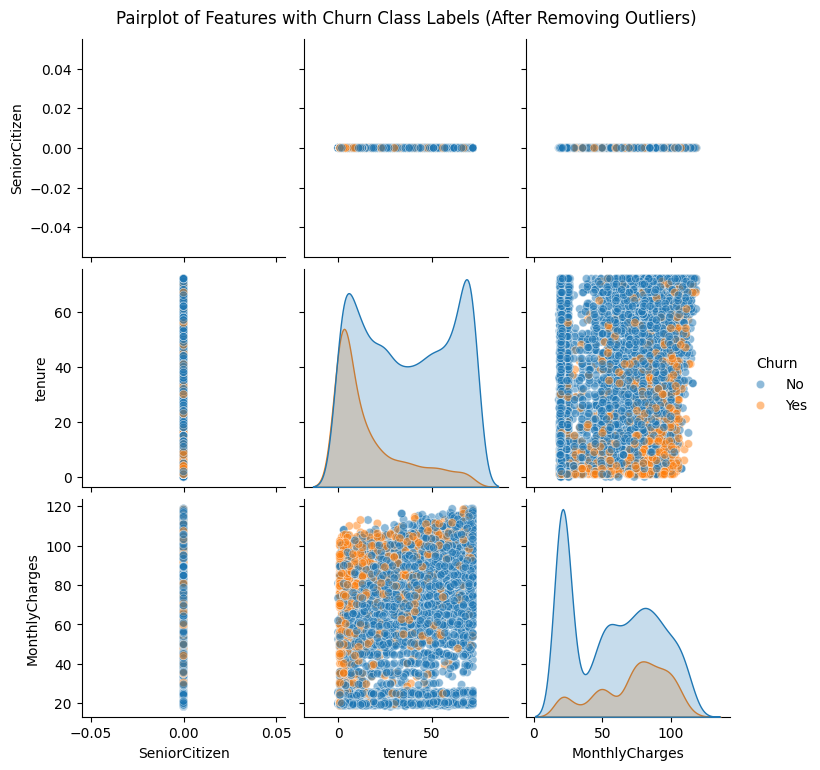

In [15]:
# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='gender', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with gender Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "chrun_removed_outliers_gender.png"))

sns.pairplot(cleaned_data, hue='Partner', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Partner Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "chrun_removed_outliers_Partner.png"))

sns.pairplot(cleaned_data, hue='Dependents', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Dependents Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "chrun_removed_outliers_Dependents.png"))

sns.pairplot(cleaned_data, hue='PhoneService', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with PhoneService Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "chrun_removed_outliers_PhoneService.png"))

sns.pairplot(cleaned_data, hue='Churn', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Churn Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "chrun_removed_outliers_Churn.png"))


In [16]:
# Step 8: Preprocess the data

# Encode the target variable
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['gender'])

In [17]:
# Step 9: Handle non-numeric columns in X

# Convert categorical features to numeric using one-hot encoding or label encoding
# Here we use LabelEncoder for each categorical column (excluding the target 'Year')
for column in data.select_dtypes(include=['object']).columns:
    if column != 'gender':  # Avoid encoding the target variable
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

In [18]:
# Step 10: Define features (X) and target (y)

X = data.drop(columns=['gender'])  # Features
y = data['gender']  # Target variable

# Step 11: Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 12: Feature scaling

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [19]:
# Step 12: Model selection and training

# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
# Step 13: Model evaluation

models = {
    "Logistic Regression": logistic_model,
    "Decision Tree": tree_model,
    "Random Forest": rf_model
}

In [21]:
# Step 14: Display metrics

# Initialize dictionaries for storing metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = {}
class_reports = {}

# Calculate metrics for each model
for model_name, model in models.items():
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average="weighted")
    recall = recall_score(y_test, pred, average="weighted")
    f1 = f1_score(y_test, pred, average="weighted")

    # Append metric scores
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Store confusion matrices and classification reports if needed
    conf_matrices[model_name] = confusion_matrix(y_test, pred)
    class_reports[model_name] = classification_report(y_test, pred)

# Creating the DataFrame with the metrics
metrics_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})

# Melt the DataFrame for easier plotting with Seaborn
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")


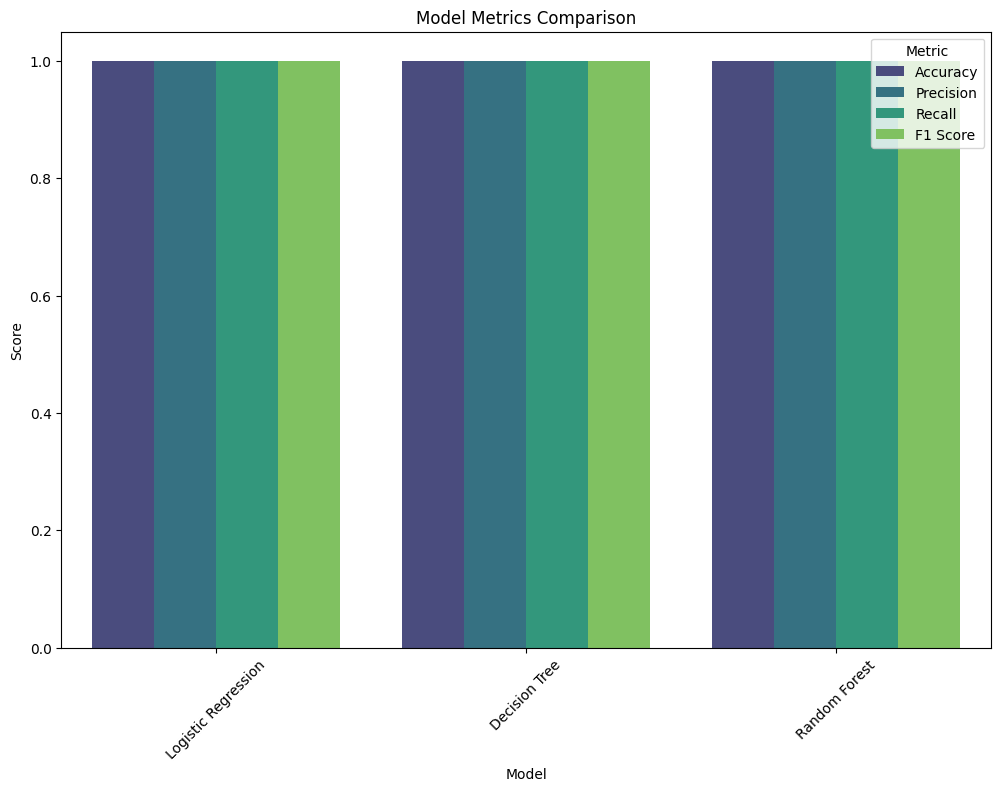

In [22]:
# Plotting the metrics
plt.figure(figsize=(12, 8))
sns.barplot(data=metrics_melted, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Model Metrics Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
# plt.show()
plt.savefig(os.path.join(output_path, "chrun_metrics.png"))


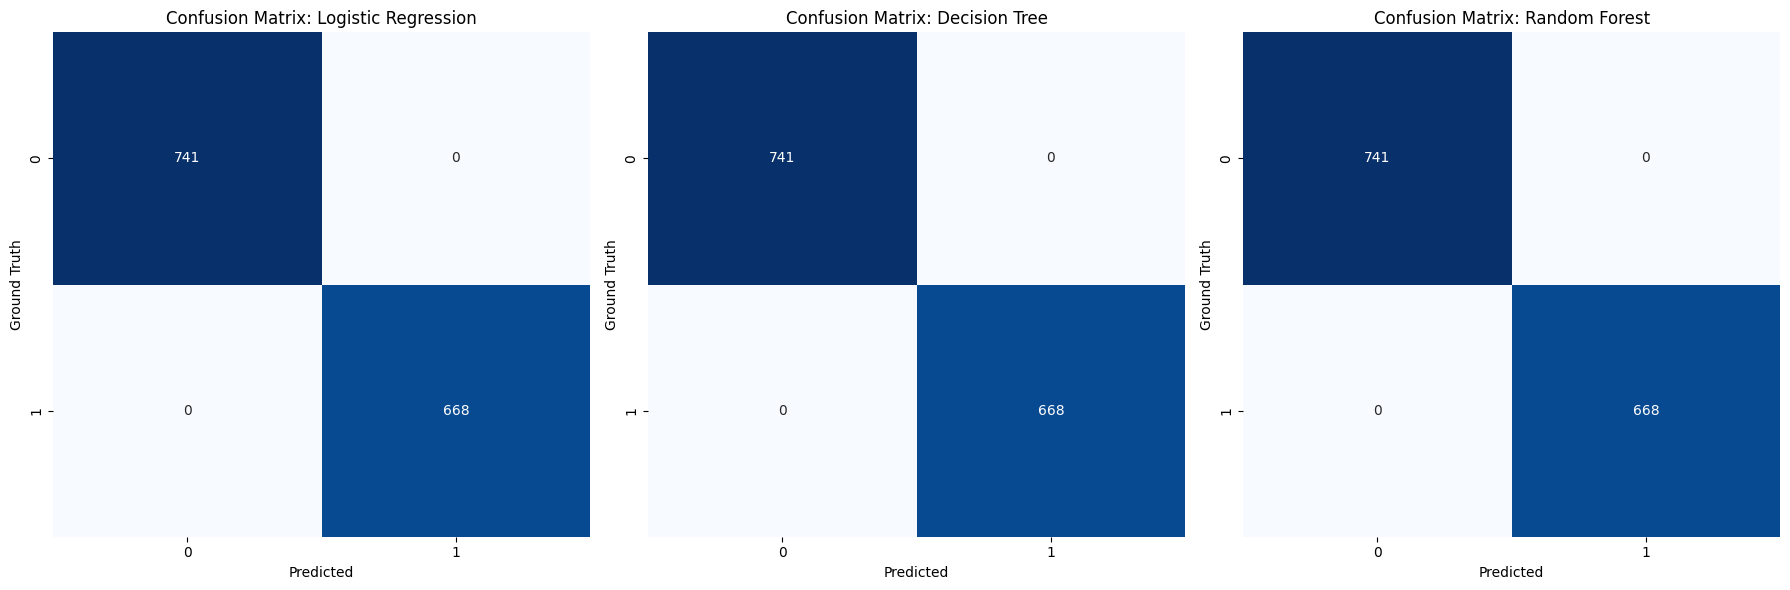

In [23]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (model_name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Ground Truth")

plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(output_path, "chrun_metrix.png"))


In [24]:
# Display classification reports
for model_name, report in class_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

      Female       1.00      1.00      1.00       741
        Male       1.00      1.00      1.00       668

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409


Classification Report for Decision Tree:
              precision    recall  f1-score   support

      Female       1.00      1.00      1.00       741
        Male       1.00      1.00      1.00       668

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409


Classification Report for Random Forest:
              precision    recall  f1-score   support

      Female       1.00      1.00      1.00       741
        Male       1.00      1.00      1.00       668

    accuracy                           1.00      1